# V code practice

Lets warp up what we talked about in the previous sections in a code example. This prepared notebook can be found on github where two thing are implemented. Loistic regression from scratch the low implementation level, implementing the learning rule. And then we move on to use the PyTorch utilities, module API that we talked previously where we had this linear layer and so forth. This is what we would do in practice when we have more complicated networks but the from scratch example is very usefull for learning perspective to get a better feeling of how logistic regression works.

### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Preparing a dataset

In [2]:
data = np.genfromtxt('../data_samples/perceptron_data.txt', delimiter='\t')

In [14]:
X = data[:, :2].astype(np.float32)
y = data[:,  2].astype(np.float32)

In [ ]:
X , y

In [12]:
def split(X, y):
    idx = np.arange(y.shape[0])
    np.random.shuffle(idx)
    
    X_test,  y_test  = X[idx[:25]], y[idx[:25]]
    X_train, y_train = X[idx[25:]], y[idx[25:]]
    
    return X_train, X_test, y_train, y_test

def normalize(data):
    mu, std = np.mean(data, axis=0), np.std(data, axis=0)
    data = data - mu / std
    return data

In [15]:
X_train, X_test, y_train, y_test = split(X, y)

In [16]:
X_train = normalize(X_train)
X_test  = normalize(X_test)

A simple binary classification data set

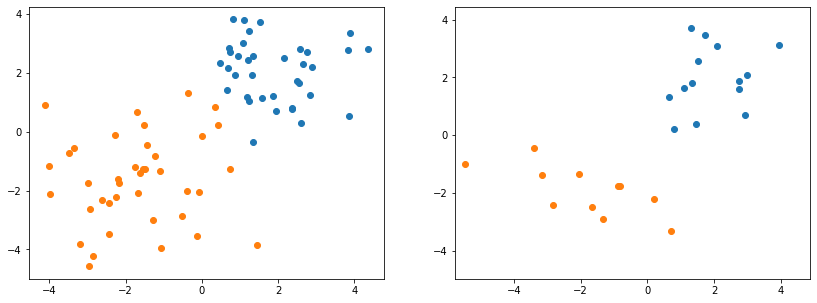

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax2.scatter(X_test[y_test == 1, 0],   X_test[y_test == 1, 1])
ax2.scatter(X_test[y_test == 0, 0],   X_test[y_test == 0, 1])

plt.xlim([x[:,0].min() - 0.5 , x[:, 0].max() + 0.5])
plt.ylim([x[:,1].min() - 0.5 , x[:, 1].max() + 0.5])

plt.show()

### Low level implementation with manual gradients

In [ ]:
device = torch.device("cuda:0" if torch.cuda_is_available() else "cpu")

class LogisticRegression_A():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(1, num_features, dtype=torch.float32, device=device)
        self.bias    = torch.zeros(1, dtype=torch.float32, device=device)
        
    def forward(self, x):
        net_input = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1)
        probas    = self._sigmoid(net_input)
        return probas
    
    def backward(self, x, y, probas):
        grad_loss_wrt_z = probas.view(-1) - y 
        grad_loss_wrt_w   = torch.mm(x.t(), grad_loss_wrt_z.view(-1, 1)).t()
        grad_loss_wrt_b   = torch.sum(grad_loss_wrt_z)
        return grad_loss_wrt_w, grad_loss_wrt_b
        
    def predict(self, x):
        probas = self.forward(x)
        labels = torch.where(probas >= .5, 1, 0)
        return labels
    
    def evaluate(self, x, y):
        labels   = self.predict(x)
        accuracy = torch.sum(labels.view(-1) == y).item() / y.size(0)
        return accuracy
    
    def _sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    def _logit_cost(self, y, proba):
        tmp1 = torch.mm(y.view(1, -1), torch.log(proba.view(-1, 1)))
        tmp2 = torch.mm((1 - y).view(1, -1), torch.log(1 - proba.view(-1, 1)))
        return tmp1 - tmp2
    
    def train(self, x, y, num_epochs, learning_rate=0.01):
        epoch_cost = []
        for e in range(num_epochs):
            probas = self.forward(x)
            
            grad_w, grad_b = self.backward(x, y , probas)
            
            self.weights -= learning_rate * grad_w
            self.bias    -= learning_rate * grad_b
            
            
            cost = self._logit_cost(y, self.forward(x)) / x.size(0)
            print('Epoch: %03d' % (e+1), end="")
            print(' | Training ACC: %.3f' % self.evaluate(x, y), end="")
            print(' | Cost: %.3f' % cost)
            
            epoch_cost.append(cost)
            
        return epoch_cost

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

In [ ]:
model = LogisticRegression_A(num_features=2)
epoch_cost = model.train(X_train_tensor, y_train_tensor, num_epochs=30, learning_rate=0.1)

print('\nModel parameters:')
print(' Weights: %s' % model.weights)
print(' Bias: %s' % model.bias)

### Evaluating the model

In [ ]:
plt.plot(epoch_cost)
plt.ylabel('Log likelihood loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [ ]:
test_acc = model.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

### 2D decision boundary

In [ ]:
w, b = model.weights.view(-1), model.bias

x_min = -2
x_max = 2
y_min = ((-(w[0] * x_min) - b[0]) / w[1])
y_max = ((-(w[0] * x_max) - b[0]) / w[1])

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=( 14, 5))

ax1.plot([x_min, x_max], [y_min, y_max])
ax2.plot([x_min, x_max], [y_min, y_max])

ax1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='0', marker='o')
ax1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='1', marker='s')

ax2.scatter(X_test[y_test == 0, 0],   X_test[y_test == 0, 1], label='0', marker='0')
ax2.scatter(X_test[y_test == 1, 0],   X_test[y_test == 1, 1], label='1', marker='s')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
plt.show()